# Whole image quality control metric evaluation

In this notebook, we will use the outputted QC metrics to start working on developing thresholds using z-score to flag and skip images during CellProfiler analysis.

**Blur metric to detect out of focus images** -> PowerLogLogSlope

**Saturation metric to detect large smudges or oversaturation** -> PercentMaximal

## Import libraries

In [1]:
import pathlib
import pandas as pd
import numpy as np

from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

## Set paths and load in data frame

In [2]:
# Directory for figures to be outputted
figure_dir = pathlib.Path("./qc_figures")
figure_dir.mkdir(exist_ok=True)

# Directory with QC CellProfiler outputs per plate
illum_dir = pathlib.Path("./whole_img_qc_output")

# Create an empty dictionary to store data frames for each plate
all_qc_data_frames = {}

# List all plate directories within the illum_dir
plates = [plate.name for plate in illum_dir.iterdir() if plate.is_dir()]

# Loop through each plate
for plate in plates:
    # Read in CSV with all image quality metrics per image for the current plate
    qc_df = pd.read_csv(illum_dir / plate / "Image.csv")

    # Store the data frame for the current plate in the dictionary
    all_qc_data_frames[plate] = qc_df

# Print the plate names to ensure they were loaded correctly
print(all_qc_data_frames.keys())

# Select the first plate in the list
first_plate = plates[0]
print(f"Showing example for the first plate: {first_plate}")

# Access the dataframe for the first plate
example_df = all_qc_data_frames[first_plate]

# Show the shape and the first few rows of the dataframe for the first plate
print(example_df.shape)
example_df.head()

dict_keys(['BR00143980', 'BR00143977', 'BR00143976', 'BR00143979', 'BR00143981', 'BR00143978'])
Showing example for the first plate: BR00143980
(2160, 147)


,ExecutionTime_01LoadData,ExecutionTime_02MeasureImageQuality,FileName_OrigAGP,FileName_OrigBrightfield,FileName_OrigDNA,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA,Group_Index,Group_Length,...,URL_OrigDNA,URL_OrigER,URL_OrigMito,URL_OrigRNA,Width_OrigAGP,Width_OrigBrightfield,Width_OrigDNA,Width_OrigER,Width_OrigMito,Width_OrigRNA
0,3.89,3.48,r03c03f01p01-ch3sk1fk1fl1.tiff,r03c03f01p01-ch1sk1fk1fl1.tiff,r03c03f01p01-ch5sk1fk1fl1.tiff,r03c03f01p01-ch2sk1fk1fl1.tiff,r03c03f01p01-ch4sk1fk1fl1.tiff,r03c03f01p01-ch6sk1fk1fl1.tiff,1,2160,...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,1080,1080,1080,1080,1080,1080
1,1.03,2.78,r03c03f02p01-ch3sk1fk1fl1.tiff,r03c03f02p01-ch1sk1fk1fl1.tiff,r03c03f02p01-ch5sk1fk1fl1.tiff,r03c03f02p01-ch2sk1fk1fl1.tiff,r03c03f02p01-ch4sk1fk1fl1.tiff,r03c03f02p01-ch6sk1fk1fl1.tiff,2,2160,...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,1080,1080,1080,1080,1080,1080
2,1.10,2.71,r03c03f03p01-ch3sk1fk1fl1.tiff,r03c03f03p01-ch1sk1fk1fl1.tiff,r03c03f03p01-ch5sk1fk1fl1.tiff,r03c03f03p01-ch2sk1fk1fl1.tiff,r03c03f03p01-ch4sk1fk1fl1.tiff,r03c03f03p01-ch6sk1fk1fl1.tiff,3,2160,...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,1080,1080,1080,1080,1080,1080
3,1.28,2.86,r03c03f04p01-ch3sk1fk1fl1.tiff,r03c03f04p01-ch1sk1fk1fl1.tiff,r03c03f04p01-ch5sk1fk1fl1.tiff,r03c03f04p01-ch2sk1fk1fl1.tiff,r03c03f04p01-ch4sk1fk1fl1.tiff,r03c03f04p01-ch6sk1fk1fl1.tiff,4,2160,...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,1080,1080,1080,1080,1080,1080
4,1.01,3.03,r03c03f05p01-ch3sk1fk1fl1.tiff,r03c03f05p01-ch1sk1fk1fl1.tiff,r03c03f05p01-ch5sk1fk1fl1.tiff,r03c03f05p01-ch2sk1fk1fl1.tiff,r03c03f05p01-ch4sk1fk1fl1.tiff,r03c03f05p01-ch6sk1fk1fl1.tiff,5,2160,...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,file:/media/18tbdrive/ALSF_pilot_data/SN031353...,1080,1080,1080,1080,1080,1080


## Create concat data frames combining blur and saturation metrics from all channels for all plates

In [3]:
# List of channels (excluding Brightfield since the metrics are not robust to this type of channel)
channels = ["OrigDNA", "OrigER", "OrigAGP", "OrigMito", "OrigRNA"]

# Create an empty dictionary to store data frames for each channel
all_combined_dfs = {}

# Iterate through each channel
for channel in channels:
    # Create an empty list to store data frames for each plate
    plate_dfs = []

    # Iterate through each plate and create the specified data frame for the channel
    for plate, qc_df in all_qc_data_frames.items():
        plate_df = qc_df.filter(like="Metadata_").copy()

        # Add PowerLogLogSlope column (blur metric)
        plate_df["ImageQuality_PowerLogLogSlope"] = qc_df[
            f"ImageQuality_PowerLogLogSlope_{channel}"
        ]

        # Add PercentMaximal column (saturation metric)
        plate_df["ImageQuality_PercentMaximal"] = qc_df[
            f"ImageQuality_PercentMaximal_{channel}"
        ]

        # Add "Channel" column
        plate_df["Channel"] = channel

        # Add "Metadata_Plate" column
        plate_df["Metadata_Plate"] = plate

        # Append the data frame to the list
        plate_dfs.append(plate_df)

    # Concatenate data frames for each plate for the current channel
    all_combined_dfs[channel] = pd.concat(
        plate_dfs, keys=list(all_qc_data_frames.keys()), names=["Metadata_Plate", None]
    )

# Concatenate the channel data frames together for plotting
df = pd.concat(list(all_combined_dfs.values()), ignore_index=True)

print(df.shape)
df.head()

(51240, 16)


,Metadata_AbsPositionZ,Metadata_ChannelID,Metadata_Col,Metadata_FieldID,Metadata_PlaneID,Metadata_Plate,Metadata_PositionX,Metadata_PositionY,Metadata_PositionZ,Metadata_Reimaged,Metadata_Row,Metadata_Site,Metadata_Well,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel
0,0.134610,6,3,1,1,BR00143980,0.000000,0.000000,-0.000006,False,3,1,C03,-2.392035,0.000086,OrigDNA
1,0.134613,6,3,2,1,BR00143980,-0.000646,0.000646,-0.000006,False,3,2,C03,-2.145481,0.000086,OrigDNA
2,0.134610,6,3,3,1,BR00143980,0.000000,0.000646,-0.000006,False,3,3,C03,-2.239991,0.000086,OrigDNA
3,0.134608,6,3,4,1,BR00143980,0.000646,0.000646,-0.000006,False,3,4,C03,-2.060386,0.000086,OrigDNA
4,0.134607,6,3,5,1,BR00143980,0.000646,0.000000,-0.000006,False,3,5,C03,-2.044405,0.000086,OrigDNA


## Blur metric

Based on the plots below, we can see that blur is a big impact on the dataset. Traditionally, we expect values close to 0 are poor quality, but we can see in these plates that values that are very negative and close to 0 are both poor quality images.

We are seeing that close to 0 images are empty and images that are very negative are very out-of-focus.

We use the z-score method to both find threshold values for identifying poor quality images above and below the mean and to output a data frame with outliers to view these images in a separate software (e.g., ImageJ/FIJI). We use **2 standard deviations** away from the mean for assessing outliers.

In [4]:
summary_statistics = df["ImageQuality_PowerLogLogSlope"].describe()
print(summary_statistics)

count    51240.000000
mean        -1.961959
std          0.334286
min         -3.617410
25%         -2.177956
50%         -1.985662
75%         -1.741658
max          0.231640
Name: ImageQuality_PowerLogLogSlope, dtype: float64


### Use z-score to find outliers 2 standard deviations above and below the mean to view as a data frame

In [5]:
# Calculate Z-scores for the column with all plates
z_scores = zscore(df["ImageQuality_PowerLogLogSlope"])

# Set a threshold for Z-scores (adjust as needed for number of standard deviations away from the mean)
blur_threshold_z = 2.5

# Identify outlier rows based on Z-scores above and below the mean (using absolute values of the z-scores)
blur_outliers = df[abs(z_scores) > blur_threshold_z]

# Filter the outliers to only include rows where Metadata_Reimaged is False to easily find images to check if threshold worked
blur_outliers_filtered = blur_outliers[~blur_outliers["Metadata_Reimaged"]]

# Filter the outliers to only include the specified columns
blur_outliers_filtered = blur_outliers_filtered[
    [
        "ImageQuality_PowerLogLogSlope",
        "Metadata_Plate",
        "Metadata_Row",
        "Metadata_Col",
        "Metadata_Site",
        "Metadata_Reimaged",
        "Channel",
    ]
]

# Identify unique well + site combos before filtering
total_unique_combos = df[["Metadata_Plate", "Metadata_Well", "Metadata_Site"]].drop_duplicates()

# Identify unique well + site combos among filtered outliers
removed_unique_combos = blur_outliers[["Metadata_Plate", "Metadata_Well", "Metadata_Site"]].drop_duplicates()

# Calculate the percentages
total_count = len(total_unique_combos)
removed_count = len(removed_unique_combos)
percentage_removed = (removed_count / total_count) * 100 if total_count > 0 else 0

# Print the percentage of unique plate-well-site combos that will be removed
print(f"Percentage of unique plate-well-site combos removed: {percentage_removed:.2f}%")

# Print example outliers (filtered columns)
print(blur_outliers["Channel"].value_counts())
blur_outliers_filtered.sort_values(by="ImageQuality_PowerLogLogSlope", ascending=False).head(100)

Percentage of unique plate-well-site combos removed: 5.88%
Channel
OrigRNA     371
OrigAGP     189
OrigDNA     154
OrigER      119
OrigMito      4
Name: count, dtype: int64


,ImageQuality_PowerLogLogSlope,Metadata_Plate,Metadata_Row,Metadata_Col,Metadata_Site,Metadata_Reimaged,Channel
19771,-0.198739,BR00143978,6,16,5,False,OrigER
19775,-0.205486,BR00143978,6,16,9,False,OrigER
43304,-0.411766,BR00143977,8,4,1,False,OrigRNA
12560,-0.480442,BR00143977,8,4,1,False,OrigER
22812,-0.577965,BR00143977,8,4,5,False,OrigAGP
...,...,...,...,...,...,...,...
50950,-2.821878,BR00143978,6,20,8,False,OrigRNA
42222,-2.822441,BR00143980,7,14,7,False,OrigRNA
46057,-2.823041,BR00143976,5,18,9,False,OrigRNA
46619,-2.823457,BR00143979,8,3,5,False,OrigRNA


### Identify threshold values to use to find outliers above and below the mean

**Note:** These values will be used in CellProfiler to flag and not process images. We will round the values to the second decimal to use in the pipeline.

In [6]:
# Calculate the mean and standard deviation
mean_value = df["ImageQuality_PowerLogLogSlope"].mean()
std_dev = df["ImageQuality_PowerLogLogSlope"].std()

# Calculate the threshold values
threshold_value_above_mean = mean_value + blur_threshold_z * std_dev
threshold_value_below_mean = mean_value - blur_threshold_z * std_dev

# Print the calculated threshold values
print("Threshold for outliers above the mean:", threshold_value_above_mean)
print("Threshold for outliers below the mean:", threshold_value_below_mean)

Threshold for outliers above the mean: -1.1262448982947686
Threshold for outliers below the mean: -2.7976730166487322


### Generate individual density plots per plate and save

In [7]:
# Set the style
sns.set_style("whitegrid")

# Iterate through each plate
for plate in df["Metadata_Plate"].unique():
    plate_df = df[df["Metadata_Plate"] == plate]

    sns.kdeplot(
        data=plate_df,
        x="ImageQuality_PowerLogLogSlope",
        hue="Channel",
        palette=["b", "g", "r", "magenta", "orange"],
        fill=True,
        common_norm=False,
    )

    plt.title(f"Density plots per channel for {plate}")
    plt.xlabel("ImageQuality_PowerLogLogSlope")
    plt.ylabel("Density")

    plt.tight_layout()
    plt.savefig(
        pathlib.Path(f"{figure_dir}/{plate}_channels_blur_density.png"), dpi=500
    )
    plt.close()  # Close the plot to prevent it from being displayed

### Generate density plot with all plates together and save

In [8]:
# Number of plates
num_plates = len(df["Metadata_Plate"].unique())

# Calculate the number of rows and columns for the subplots
num_rows = 2  # You want 2 rows for the quad order
num_cols = (num_plates + 1) // num_rows  # +1 to round up

# Set the style
sns.set_style("whitegrid")

# Create subplots with custom layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through each plate
for idx, plate in enumerate(df["Metadata_Plate"].unique()):
    # Plot all channels in the same subplot
    ax = axes[idx]
    plate_df = df[df["Metadata_Plate"] == plate]
    sns.kdeplot(
        data=plate_df,
        x="ImageQuality_PowerLogLogSlope",
        hue="Channel",
        palette=["b", "g", "r", "magenta", "orange"],
        fill=True,
        common_norm=False,
        ax=ax,
    )

    # Set vertical lines at thresholds above and below mean
    ax.axvline(x=threshold_value_above_mean, color="red", linestyle="--")
    ax.axvline(x=threshold_value_below_mean, color="red", linestyle="--")

    ax.set_title(f"Density plots for {plate}")
    ax.set_xlabel("ImageQuality_PowerLogLogSlope")
    ax.set_ylabel("Density")

    # Set the x-axis range for the current subplot
    ax.set_xlim(-4.0, 0)

# Remove empty subplots
for i in range(num_plates, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig(figure_dir / "all_channels_combined_density.png", dpi=500)

plt.close()  # Close the plot to prevent it from being displayed

### Visualize the distribution of the identified outliers

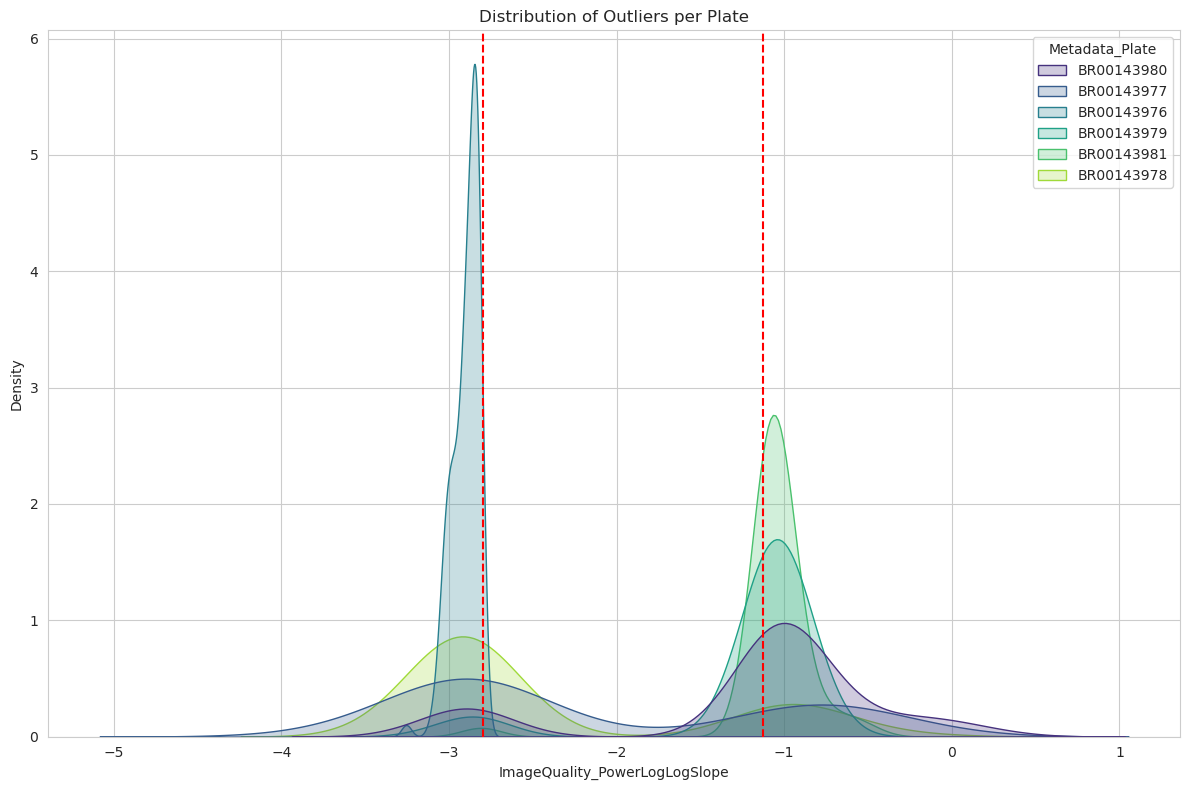

In [9]:
# Plot outliers as a distribution plot with hue as 'Metadata_Plate'
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Using kdeplot (you can also use distplot)
sns.kdeplot(
    data=blur_outliers,
    x="ImageQuality_PowerLogLogSlope",
    hue="Metadata_Plate",
    palette="viridis", 
    fill=True,
    common_norm=False,
)

# Set vertical lines for outlier thresolds
plt.axvline(x=threshold_value_above_mean, color="red", linestyle="--")
plt.axvline(x=threshold_value_below_mean, color="red", linestyle="--")

plt.title("Distribution of Outliers per Plate")
plt.xlabel("ImageQuality_PowerLogLogSlope")

plt.tight_layout()

plt.savefig(figure_dir / "blur_outliers_per_plate.png", dpi=500)

plt.show()

## Saturation metric

For saturation metrics, we are looking for:

- Smudged images or images containing large artifacts
- Overly saturated channels which can occur in any channel

This means that we will be setting a threshold for outliers for all channels just like for blur. There will be only one threshold for images that are above the mean since we are trying to remove over-saturated or images contain artifacts.

In [10]:
summary_statistics = df["ImageQuality_PercentMaximal"].describe()
print(summary_statistics)

count    51240.000000
mean         0.172881
std          2.051190
min          0.000086
25%          0.000086
50%          0.000086
75%          0.001629
max         93.701217
Name: ImageQuality_PercentMaximal, dtype: float64


### Use z-score to find outliers 2 standard deviations above the mean to view as a data frame

In [11]:
# Calculate Z-scores for the column
z_scores = zscore(df["ImageQuality_PercentMaximal"])

# Set a threshold for Z-scores (adjust as needed for number of standard deviations away from the mean)
saturation_threshold_z = 2

# Identify outlier rows based on Z-scores greater than as to identify whole images with abnormally high saturated pixels
saturation_outliers = df[abs(z_scores) > saturation_threshold_z]

# Identify unique well + site combos before filtering
total_unique_combos = df[["Metadata_Plate", "Metadata_Well", "Metadata_Site"]].drop_duplicates()

# Identify unique well + site combos among filtered outliers
removed_unique_combos = saturation_outliers[["Metadata_Plate", "Metadata_Well", "Metadata_Site"]].drop_duplicates()

# Calculate the percentages
total_count = len(total_unique_combos)
removed_count = len(removed_unique_combos)
percentage_removed = (removed_count / total_count) * 100 if total_count > 0 else 0

# Print the percentage of unique plate-well-site combos that will be removed
print(f"Percentage of unique plate-well-site combos removed: {percentage_removed:.2f}%")

# Filter the outliers to only include rows where Metadata_Reimaged is False to easily find images to check if threshold worked
saturation_outliers_filtered = saturation_outliers[~saturation_outliers["Metadata_Reimaged"]]

# Filter the outliers to only include the specified columns
saturation_outliers_filtered = saturation_outliers_filtered[
    [
        "ImageQuality_PercentMaximal",
        "Metadata_Plate",
        "Metadata_Row",
        "Metadata_Col",
        "Metadata_Site",
        "Metadata_Reimaged",
        "Channel",
    ]
]

# Visualize example images through FIJI using data frame identifying outliers
print(saturation_outliers["Channel"].value_counts())
saturation_outliers_filtered.sort_values(by="ImageQuality_PercentMaximal", ascending=False).head()

Percentage of unique plate-well-site combos removed: 2.84%
Channel
OrigMito    286
OrigER        5
OrigRNA       3
OrigDNA       1
Name: count, dtype: int64


,ImageQuality_PercentMaximal,Metadata_Plate,Metadata_Row,Metadata_Col,Metadata_Site,Metadata_Reimaged,Channel
31629,93.701217,BR00143980,5,11,4,False,OrigMito
31628,89.789866,BR00143980,5,11,3,False,OrigMito
31737,78.308899,BR00143980,5,12,4,False,OrigMito
31630,67.730024,BR00143980,5,11,5,False,OrigMito
31647,66.936385,BR00143980,7,11,4,False,OrigMito


### Identify threshold values to use to find outliers above the mean

**Note:** This value will be used in CellProfiler to flag and not process images. We will round to the second decimal to use in the pipeline.

In [12]:
# Calculate the mean and standard deviation
mean_value = df["ImageQuality_PercentMaximal"].mean()
std_dev = df["ImageQuality_PercentMaximal"].std()

# Calculate the threshold values
threshold_value_above_mean = mean_value + saturation_threshold_z * std_dev

# Print the calculated threshold values
print("Threshold for outliers above the mean:", threshold_value_above_mean)

Threshold for outliers above the mean: 4.275261792593619


### Visualize density plot of saturation metric

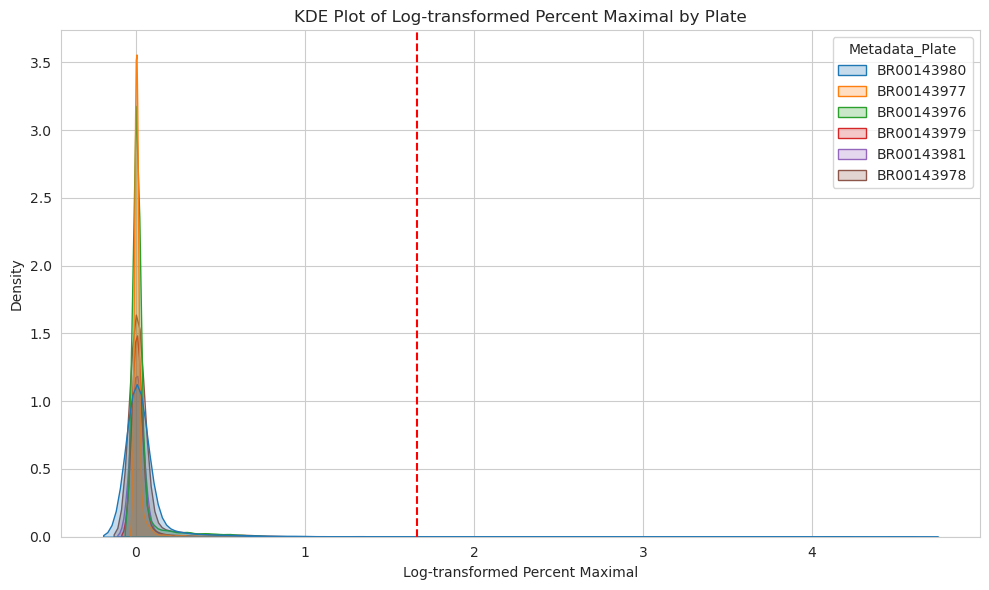

In [13]:
# Create a KDE plot with separate lines for each Metadata_Plate
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=np.log1p(df["ImageQuality_PercentMaximal"]), hue=df["Metadata_Plate"], fill=True
)

# Add a vertical line at the log-transformed value of the threshold for saturation
plt.axvline(x=np.log1p(threshold_value_above_mean), color='red', linestyle='--', label='Log-transformed 1.4')

# Set labels and title
plt.ylabel("Density")
plt.xlabel("Log-transformed Percent Maximal")
plt.title("KDE Plot of Log-transformed Percent Maximal by Plate")
plt.tight_layout()

plt.savefig(figure_dir / "saturation_outliers_per_plate.png", dpi=500)

# Show the plot
plt.show()